# Modeling Angular Power Spectrum

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from modules import init_cosmology, init_sample, Model
from test import test_pk, test_cl_rsd
from scipy.optimize import curve_fit


from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.special import eval_legendre as scipyLeg
from time import time
import logging

import healpy as hp
from tqdm.notebook import tqdm

import sys
sys.path.insert(0, '/Users/rezaie/github/LSSutils')
from lssutils.clustering import ddthetahpauto
from lssutils.stats.cl import AnaFast
from lssutils.utils import mask2regions
from lssutils import setup_logging

In [5]:
from lssutils.utils import histogram_cell

In [6]:
plt.rc('font', size=15)
plt.rc('figure', figsize=(8, 5))

In [7]:
setup_logging('info')

## Make sample

In [8]:
lmax = 500
cosmo = init_cosmology()
z, b, dNdz = init_sample()

#lt = np.array([3, 5, 7, 9, 11, 13, 15, 17, 19, 26, 48, 96, 192, 384]) #np.arange(2, 500)
lt = np.arange(5000)
th = Model(cosmo, has_rsd=True, has_fnl=True)
th.add_tracer(z, b, dNdz)
cl_null = th(lt, fnl=0.0)
cl_fnlp = th(lt, fnl=10.0)
cl_fnln = th(lt, fnl=-10.0)

will create windows


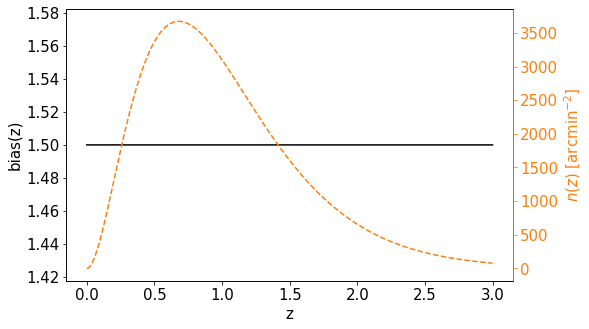

In [9]:
fg, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(z, b, 'k-', label='Bias')
ax2.plot(z, dNdz, 'C1--', label='Redshift Distribution')

ax1.set(xlabel='z', ylabel='bias(z)')
ax2.set_ylabel(r'$n(z)~[{\rm arcmin}^{-2}]$', color='C1')
ax2.spines['right'].set_color('C1')
ax2.tick_params(axis='both', colors='C1')
# ax1.legend()
# ax2.legend(frameon=False)

# fg.savefig('sample.png', dpi=300, bbox_inches='tight')

## Survey Window

In [10]:
def poly(x, *params):
    ans = params[0]
    for i in range(1, len(params)):
        ans += np.power(x, i)*params[i]
    return ans


def gauleg(ndeg, a=-1.0, b=1.0):
    '''
       Gauss-Legendre (default interval is [-1, 1])
    '''
    x, w = np.polynomial.legendre.leggauss(ndeg)
    # Translate x values from the interval [-1, 1] to [a, b]
    t = 0.5*(x + 1)*(b - a) + a
    w *= 0.5*(b - a)
    return t, w

def xi2cl(x, w, xi, nlmax):
    '''
        calculates Cell from omega
    '''
    cl  = []
    xiw = xi*w
    for i in range(nlmax+1):
        Pl    = np.polynomial.Legendre.basis(i)(x)
        cl.append((xiw * Pl).sum())
        
    cl = 2.*np.pi*np.array(cl)
    return cl

def cl2xi(cell, costheta):
    '''
        calculates omega from Cell at Cos(theta)
    '''
    ell = np.arange(cell.size)
    coef = (2*ell+1) * cell / (4.*np.pi)
    y = np.polynomial.legendre.legval(costheta, c=coef, tensor=False)
    return y


class CellTheory:
    
    logger = logging.getLogger('CellTheory')
    
    def __init__(self, 
                 cellfile='/Volumes/TimeMachine/data/mocks/fftloggz0.85redbias2.out',
                 lmax=10000):
        
        self.l_mod, self.cl_mod = np.loadtxt(cellfile, usecols=(0,1), unpack=True)
        
        self.lmax = int(self.l_mod.max())
        self.lmin = int(self.l_mod.min())
        
        self.logger.info(f'ellmin = {self.lmin}, C_ellmin = {self.cl_mod[0]}')        
        self.logger.info(f'ellmax = {self.lmax}, C_ellmax = {self.cl_mod[-1]}')  
        
        if self.lmin != 0.0:
            self.logger.warning(f'insert 0.0 for ell=0')
            self.cl_mod = np.insert(self.cl_mod, 0, 0.0)
                
        if lmax > self.lmax:
            self.logger.info(f'extend to {lmax}')
            self._extend(lmax)
            self.lmax = lmax

    def convolve(self, XIW, lmax=512, ngauss=4*1024):
        assert lmax <= self.lmax, 'lmax is too high'
        t0 = time()
        #--- convolve the theory with the window
        cos_sep, weights = np.polynomial.legendre.leggauss(ngauss)
        mid_sep = np.arccos(cos_sep)

        xi_window = XIW(mid_sep)
        xi_model = self.toxi(cos_sep)

        t1 = time()
        print(f'cl2xi : {t1-t0:6.1f} s')

        xi_mod_wind = xi_model * xi_window
        #scalefactor = xi_model.sum()/xi_mod_wind.sum()
        #xi_mod_wind *= scalefactor
        cl_mod_wind = xi2cl(cos_sep, weights, xi_mod_wind, lmax)

        t2 = time()

        print(f'xi2cl : {t2-t1:6.1f} s')


        return {'ell':np.arange(lmax+1), 
               'Cell':self.cl_mod_ex[:lmax+1],
               'Cellconv':cl_mod_wind,
               'Xiwindow':xi_window,
               'Ximodel':xi_model}    
        
    def _extend(self, lmax):
        
        # fit
        self.params,_ = curve_fit(self._lncl, 
                                  np.log(self.l_mod[-10:]),
                                  np.log(self.cl_mod[-10:]), 
                                  p0=[1., 0.])
        
        clmod_ext = list(self.cl_mod)
        for ell in range(self.lmax, lmax+1):
            clmod_ext.append(np.exp(self._lncl(np.log(ell), *self.params)))
        
        self.cl_mod_ex = np.array(clmod_ext)
        
        
    def _lncl(self, lnl, *params):
        return params[0]+lnl*params[1]-(np.exp(lnl)/self.lmax-1.)
                                
        
    def toxi(self, cos_sep):
        return cl2xi(self.cl_mod_ex, cos_sep)
    
    def plot(self, ax=None, **kwargs):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
            
        if hasattr(self, 'cl_mod_ex'):
            ax.plot(self.cl_mod_ex, 'y-')
            
        ax.plot(self.cl_mod, 'g--')        
        ax.set(xscale='log', xlabel=r'$\ell$', ylabel=r'C$_\ell$')
        
    def load(self, 
             ximodel='/Volumes/TimeMachine/data/DR7/theta_omega_theory.txt'):
        self.sep_rad, self.xi_mod = np.loadtxt(ximodel).T
        self.dsep_rad = np.diff(self.sep_rad)
        
        
class XiWindow:
    
    def __init__(self, 
                 xifile='/Volumes/TimeMachine/data/DR7/dr7_window.cut.256.npy',
                 dof=8,
                 nside=256,
                 ntot=1.0):
        '''
        '''
        npix = 12*nside*nside
        norm = (2./(npix*ntot))
        
        result   = np.load(xifile, allow_pickle=True)
        sep      = result[0]
        self.rr  = result[1]*2.0
        if sep[0] > sep[1]:
            print('reordering arrays i.e., increasing')
            sep  = sep[::-1]
            self.rr  = self.rr[::-1]
        
        self.mid_sep = 0.5*(sep[:-1]+sep[1:])
        self.dsep = np.diff(sep)
        
        # norm
        self.rr_normed = norm*self.rr / (np.sin(self.mid_sep)*self.dsep)
        self.rr_fn = IUS(self.mid_sep, self.rr_normed)
        #self.rr_normed /= self.rr_normed[0]
        
        # fit
        self._fit(dof)
        #norm = self(0.0)
        
        # renormaliza
        #self.params = [p/norm for p in self.params]
        #self.rr_normed /= norm
        
    def __call__(self, mid_sep):
        return poly(mid_sep, *self.params)
    
    
    def _fit(self, dof=8, nmodes_ext=50):
        mid_sep_ext = list(self.mid_sep)
        rr_ext = list(self.rr_normed)

        for j in range(nmodes_ext):
            # right end
            mid_sep_ext.append(self.mid_sep[-1]+(j+1)*self.dsep[-1-j])
            rr_ext.append(self.rr_normed[-1-j])

            # left end
            #mid_sep_ext.insert(0, xi_wind.mid_sep[0]-(j+1)*xi_wind.dsep[0])
            #rr_ext.insert(0, xi_wind.rr_normed[j+1])

        p0 = [0 for i in range(dof)]
        self.params,_ = curve_fit(poly, mid_sep_ext, rr_ext, p0=p0) 

In [11]:
af = AnaFast()

In [12]:
mask_ = hp.read_map('/Volumes/TimeMachine/data/DR7/mask.cut.hp.256.fits', verbose=False) > 0
mask = mask2regions(mask_)[0] # NGC

nside = 256
#ell, cl_th = np.loadtxt('C_ells_bin1_1_linear.txt').T
weight1 = np.ones(12*nside*nside)
mask1 = weight1 > 0

/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


In [17]:
# # create one for Alex
# np.random.seed(42)
# map1 = hp.synfast(cl_th, nside, pol=False)
# data = {'mask':mask, 'map':map1}
# np.savez('./mock_seed42.npz', **data)

# mock_data = np.load('./mock_seed42.npz', allow_pickle=True)
# print(f"files: {mock_data.files}")
# print(f"mask: {mock_data['mask']}")
# print(f"map: {mock_data['map']}")

files: ['mask', 'map']
mask: [False False False ... False False False]
map: [-0.01114036  0.07415994  0.00440039 ... -0.00934828 -0.09088138
 -0.01094798]


In [29]:
# # run once
# cls = {'full':[], 'masked':[]}
# cls['true'] = cl_th

# nmocks = 2000
# np.random.seed(42)
# seeds = np.random.randint(0, 2**32-1, size=nmocks)
# print(np.unique(seeds).size)
# for seed in tqdm(seeds):
    
#     np.random.seed(seed)
#     map1 = hp.synfast(cl_th, nside, pol=False)
#     #map1 = map1 - map1.sum()
#     #map2 = map1 - map1[mask].sum()
    
#     #print(map1[mask1].mean(), map2[mask].mean())
    
#     cls['full'].append(af(map1, weight1, mask1)['cl'])
#     cls['masked'].append(af(map1, weight1, mask)['cl'])
# np.savez('./cl_mocks_1k', **cls)    

2000


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


In [13]:
cls = np.load('cl_mocks_1k.npz', allow_pickle=True)
len(cls['full'])

2000

In [14]:
cl_mask_raw = af(mask*1.0, weight1, mask, lmax=767)
xi_zero = (cl_mask_raw['cl']*(2*cl_mask_raw['l']+1)).sum() / (4.*np.pi)

In [15]:
x, w = gauleg(2**12)
xi_mask = cl2xi(cl_mask_raw['cl'], x) / xi_zero

In [15]:
# params = curve_fit(poly, np.log(cl_mask_raw['l'][1:]), np.log(cl_mask_raw['cl'][1:]), 3*[0.1])
# cl_mask = np.exp(poly(np.log(np.arange(0, 5000.)), *params[0]))
# cl_mask[0] = cl_mask_raw['cl'][0]
# xi_mask2 = cl2xi(cl_mask, x)

#plt.plot(np.arccos(x)*180./np.pi, xi_mask)
#plt.plot(np.arccos(x)*180./np.pi, xi_mask2/xi_mask2[-1])
# plt.plot(np.arccos(x)*180./np.pi, xi_mask_fit)
#plt.xscale('log')
# plt.ylim(0.0, 1.0)
# plt.yscale('log')

In [17]:
xi_th = cl2xi(cl_null, x)
xi_thw = xi_th * xi_mask
cl_thw = xi2cl(x, w, xi_thw, 767)

# plt.plot(180.*np.arccos(x)/np.pi, xi_th,
#          180.*np.arccos(x)/np.pi, xi_thw)
# #          180.*np.arccos(x)/np.pi, xi_obs)
# # plt.xscale('log')
# plt.yscale('log')

In [55]:
# # read paircount
# paircount = './rr_window_fix.npy'
# XIW = XiWindow(paircount, dof=11, ntot=107300.)

# # ---  theoretical C_ell ---
# fftlog = './C_ells_bin1_1_linear.txt'
# CFFT = CellTheory(fftlog)
# clwind = CFFT.convolve(XIW.rr_fn, lmax=lmax, ngauss=2048)

[ 006794.11 ]   0: 04-01 23:39  CellTheory      INFO     ellmin = 0, C_ellmin = 4.93786e-07
[ 006794.11 ]   0: 04-01 23:39  CellTheory      INFO     ellmax = 499, C_ellmax = 9.35132e-08
[ 006794.11 ]   0: 04-01 23:39  CellTheory      INFO     extend to 10000


reordering arrays i.e., increasing
cl2xi :    0.8 s
xi2cl :    2.5 s


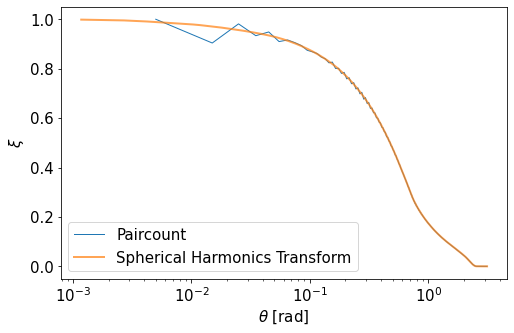

In [23]:
plt.plot(XIW.mid_sep, XIW.rr_normed, 'C0-', lw=1.0)
# plt.plot(np.arccos(x), XIW(np.arccos(x)), 'C0--', lw=2, alpha=0.9)
plt.plot(np.arccos(x), xi_mask, 'C1-', lw=2, alpha=0.7)
plt.legend(['Paircount', 
            #'Paircount (polynomial fit)',
            'Spherical Harmonics Transform'])
plt.xscale('log')
plt.xlabel(r'$\theta$ [rad]')
plt.ylabel(r'$\xi$')
#plt.yscale('log')
plt.savefig('xi_window.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, '$10^{6}C_{\\ell}$')

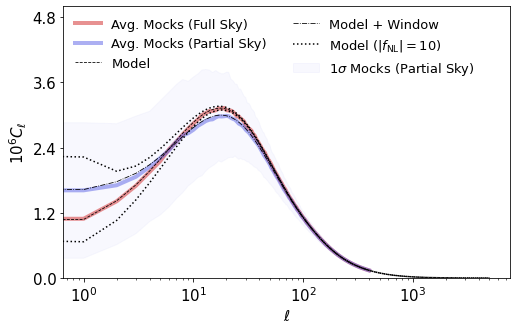

In [21]:
cl_mean = np.mean(cls['masked'], axis=0)
min_, max_ = np.percentile(cls['masked'], [16, 84], axis=0)
std_ = np.std(cls['masked'], axis=0)/np.sqrt(2000.)



plt.plot(np.mean(cls['full'], axis=0)[:400], ls='-', c='#d12424', alpha=0.5, lw=4, zorder=-1, label='Avg. Mocks (Full Sky)')
plt.plot(cl_mean[:400], ls='-', c='#5a61e6', alpha=0.5, lw=4, zorder=-1, label='Avg. Mocks (Partial Sky)')
plt.fill_between(np.arange(400), min_[:400], max_[:400], color='#5a61e6', alpha=0.04, zorder=-2, label=r'$1 \sigma$ Mocks (Partial Sky)')

#for ix in np.random.choice(np.arange(len(cls['masked'])), size=100, replace=False):
#    plt.plot(cls['masked'][ix][:400], ls='--', c='#5a61e6', alpha=0.8, lw=0.1, zorder=-1)


plt.plot(cl_null, c='k', ls='--', lw=0.8, label='Model')
plt.plot(cl_thw[:400], c='k', ls='-.', lw=0.8, label='Model + Window')
# plt.plot(clwind['ell'], clwind['Cellconv'], 'C9-.', label='Model + Window (RR)')

plt.plot(lt, cl_fnln, 'k:', label=r'Model ($|f_{\rm NL}|=10$)')
plt.plot(lt, cl_fnlp, 'k:')

plt.legend(frameon=False, loc='upper left',
           fontsize=13, ncol=2,
          )
plt.ylim(8.0e-8, 5.0e-6)
# plt.yscale('log')

plt.yticks([0.0, 1.2e-6, 2.4e-6, 3.6e-6, 4.8e-6], labels=[0.00, 1.2, 2.4, 3.6, 4.8])

plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$10^{6}C_{\ell}$')
# plt.savefig('mocks_cl.png', dpi=300, bbox_inches='tight', facecolor='w')

In [20]:
cl_null

array([4.70491659e-07, 1.07911316e-06, 1.42210992e-06, ...,
       5.35704000e-10, 5.35439098e-10, 5.35174377e-10])

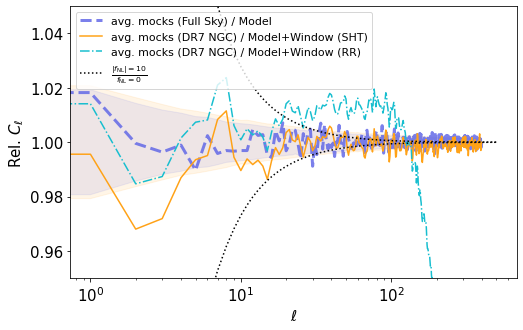

In [21]:
cl_mean_f = np.mean(cls['full'], axis=0)[:400]
std_f = np.std(cls['full'], axis=0)[:400]/np.sqrt(2000.)
cl_mean_m = np.mean(cls['masked'], axis=0)[:400]
std_m = np.std(cls['masked'], axis=0)[:400]/np.sqrt(2000.)


plt.plot(cl_mean_f/cls['true'][:400], ls='--', c='#5a61e6', alpha=0.8, lw=3, zorder=-1, label='avg. mocks (Full Sky) / Model')
plt.plot(cl_mean_m/cl_thw[:400], ls='-', color='#ffa217', label='avg. mocks (DR7 NGC) / Model+Window (SHT)')
plt.plot(cl_mean_m/(clwind['Cellconv'][:400]), ls='-.', color='C9', label='avg. mocks (DR7 NGC) / Model+Window (RR)')


plt.fill_between(np.arange(400), 1.0-std_f[:400]/cls['true'][:400], 1.0+std_f[:400]/cls['true'][:400], color='#5a61e6', alpha=0.1, zorder=-1)
plt.fill_between(np.arange(400), 1.0-std_m[:400]/cl_thw[:400], 1.0+std_m[:400]/cl_thw[:400], color='#ffa217', alpha=0.1, zorder=-2)


plt.plot(lt, cl_fnln/cl_null, 'k:', label=r'$\frac{|f_{\rm NL}|=10}{f_{\rm NL}=0}$')
plt.plot(lt, cl_fnlp/cl_null, 'k:')

plt.ylim(0.95, 1.05)
plt.legend(frameon=True, fontsize=11)#, bbox_to_anchor=(0.4, 1.1))
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'Rel. $C_{\ell}$')
plt.savefig('mocks_relcl.png', dpi=300, bbox_inches='tight', facecolor='w')

In [31]:
from lssutils.dataviz import mycolor

In [33]:
map2 = hp.ma(map1)
map2.mask = np.logical_not(mask)

/Users/rezaie/anaconda3/envs/sysnet/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


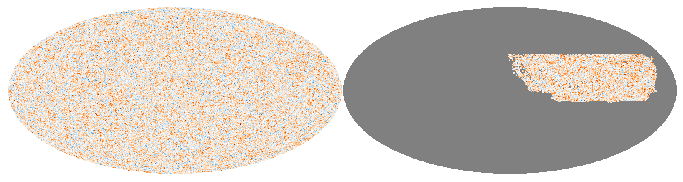

In [50]:
fg, ax = plt.subplots(ncols=2, figsize=(12, 3.5))
fg.subplots_adjust(wspace=0.0)


for i, map_ in enumerate([map1, map2.filled()]):
    plt.sca(ax[i])
    cmap_ = hp.mollview(map_, title='', cmap=mycolor(), hold=True, rot=-85, cbar=False, )
fg.savefig('mocks_hp.png', dpi=300, bbox_inches='tight')

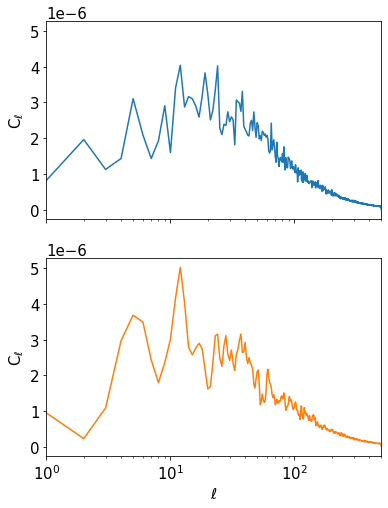

In [105]:
fig, ax = plt.subplots(nrows=2, figsize=(6, 8), sharey=True, sharex=True)

ax[0].plot(cls['full'][-1], 'C0')
ax[1].plot(cls['masked'][-1], 'C1')

ax[0].set_xlim(1, 500)
ax[0].set_xscale('log')
ax[1].set_xlabel(r'$\ell$')
for axi in ax:axi.set_ylabel(r'C$_{\ell}$')
# plt.yscale('log')
# plt.ylim(8.0e-8, 1.0e-5)

## FNL

In [56]:
cosmo = init_cosmology()
z, b, dNdz = init_sample()

ell = np.arange(2, 500)
th = Model(cosmo)
th.add_tracer(z, b, dNdz)
cl_null = th.compute_cl(ell, fnl=0.0, has_rsd=True, has_fnl=False)
cl_fnlp = th.compute_cl(ell, fnl=100.0, has_rsd=True, has_fnl=True)
cl_fnln = th.compute_cl(ell, fnl=-100.0, has_rsd=True, has_fnl=True)

100%|██████████| 498/498 [00:00<00:00, 2185.84it/s]


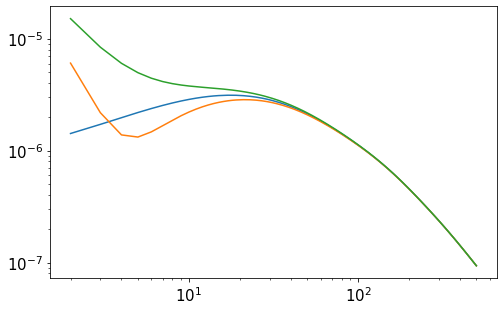

In [57]:
for cli in [cl_null, cl_fnln, cl_fnlp]:
    plt.loglog(ell, cli)

## Testing the pipeline

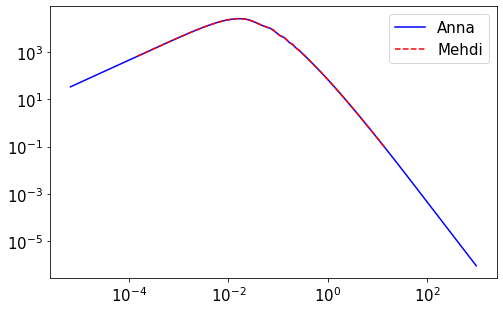

In [58]:
test_pk()

100%|██████████| 498/498 [00:00<00:00, 2217.81it/s]


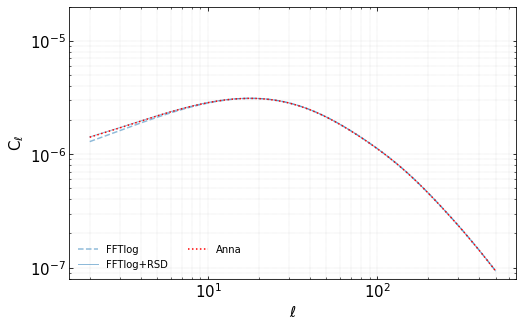

In [59]:
test_cl_rsd()

In [12]:
import camb
from camb import model, initialpower
from camb.sources import SplinedSourceWindow

In [13]:
_h = 0.6777
_h2 = _h*_h
_Ob0 = 0.048206
_Ocdm0 = 0.307115 - _Ob0
_ns = 0.9611
_Tcmb = 2.7255
_sigma8 = 0.8225
As = 2.0e-9


# cosmo = ccl.Cosmology(Omega_c=_Ocdm0, Omega_b=_Ob0, h=_h, 
#                       n_s=_ns, sigma8=_sigma8,
#                       T_CMB=_Tcmb, transfer_function='boltzmann_camb', 
#                       matter_power_spectrum='linear') 

In [14]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=_h*100, ombh2=_Ob0*_h2, omch2=_Ocdm0*_h2, ) # planck 2015
pars.InitPower.set_params(As=As, ns=_ns)
pars.WantTransfer = True
pars.set_matter_power(redshifts=(0.0, ), nonlinear=False)
pars.set_for_lmax(2000, lens_potential_accuracy=1)
#pars.Want_CMB_lensing = False

pars.SourceTerms.counts_density = True
#pars.SourceTerms.counts_evolve = False
#pars.SourceTerms.counts_timedelay = False
#pars.SourceTerms.counts_ISW = False
#pars.SourceTerms.counts_potential = False
pars.DoLensing = False
#pars.Want_CMB = False
pars.NonLinear = model.NonLinear_none
pars.SourceTerms.counts_redshift = False 
pars.SourceWindows = [SplinedSourceWindow(bias=1.5, dlog10Ndm=-0.2, z=z, W=dNdz)]

In [15]:
results = camb.get_results(pars)
cls_camb = results.get_source_cls_dict(raw_cl=True)

In [16]:
pars.SourceTerms.counts_redshift = True
pars.SourceTerms.counts_velocity = True
results_r = camb.get_results(pars)
cls_camb_r = results_r.get_source_cls_dict(raw_cl=True)

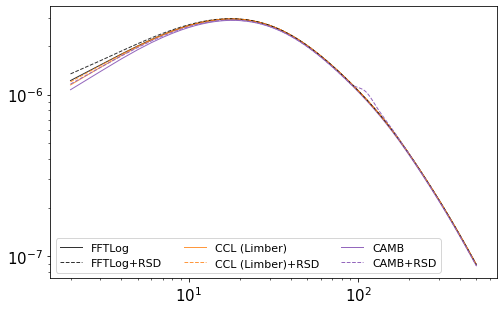

In [23]:
plt.plot(ell, th.cl, 'k-', alpha=0.8, label='FFTLog', lw=1, zorder=-1)
plt.plot(ell, th.cl_rsd, 'k--', alpha=0.8, label='FFTLog+RSD', lw=1)
plt.plot(ell, cls_ccl,'C1-', alpha=0.8, label='CCL (Limber)', lw=1, zorder=-1)
plt.plot(ell, cls_ccl_rsd,'C1--', alpha=0.8, label='CCL (Limber)+RSD', lw=1)
plt.plot(ell, cls_camb['W1xW1'][2:500],'C4-', label='CAMB', lw=1, zorder=-1)
plt.plot(ell, cls_camb_r['W1xW1'][2:500],'C4--', label='CAMB+RSD', lw=1)
# plt.legend(['FFTlog', 'CCL (Limber)'], frameon=False) # , 'CCL+RSD'
plt.legend(ncol=3, fontsize=11)
plt.xscale('log')
plt.yscale('log')
# plt.xlabel(r'$\ell$')
# plt.ylabel(r'C$_{\ell}$')
plt.savefig('cl_fftlog_ccl_camb.png', dpi=300, bbox_inches='tight', facecolor='w')

In [17]:
import pyccl as ccl

In [18]:
pk = lambda k:ccl.linear_matter_power(cosmo, k, 1.0)

In [25]:
kc, _, pkc = results.get_matter_power_spectrum()

[]

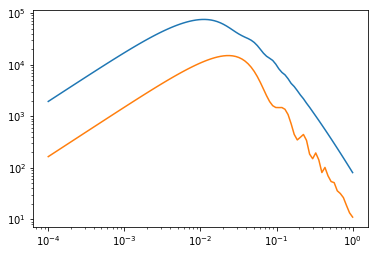

In [26]:
plt.plot(kc, pk(kc),
        kc, pkc.flatten())
plt.loglog()

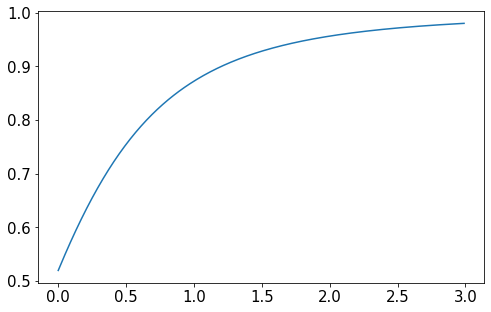

In [24]:
plt.plot(z, th.f(z))

In [26]:
z[::10]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9])

In [27]:
1./(1+z[::10])

array([1.        , 0.90909091, 0.83333333, 0.76923077, 0.71428571,
       0.66666667, 0.625     , 0.58823529, 0.55555556, 0.52631579,
       0.5       , 0.47619048, 0.45454545, 0.43478261, 0.41666667,
       0.4       , 0.38461538, 0.37037037, 0.35714286, 0.34482759,
       0.33333333, 0.32258065, 0.3125    , 0.3030303 , 0.29411765,
       0.28571429, 0.27777778, 0.27027027, 0.26315789, 0.25641026])

## With RSD

In [6]:
import pyccl as ccl

In [7]:
help(ccl.growth_rate)

Help on function growth_rate in module pyccl.background:

growth_rate(cosmo, a)
    Growth rate defined as the logarithmic derivative of the
    growth factor, dlnD/dlna.
    
    Args:
        cosmo (:class:`~pyccl.core.Cosmology`): Cosmological parameters.
        a (float or array_like): Scale factor(s), normalized to 1 today.
    
    Returns:
        float or array_like: Growth rate.



In [10]:
Om = cosmo.cosmo.params.Omega_m

In [15]:
#Omega_M = ( Omega_M_0 * (1+z)^3  ) / ( Omega_M_0*(1+z)^3 + Omega_Lambda)
omega_r = lambda z:(Om*(1.+z)**3)/(Om*(1.+z)**3 + 1.-Om)

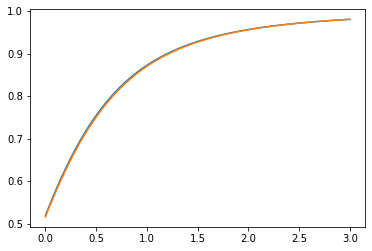

In [21]:
plt.plot(z, ccl.growth_rate(cosmo, 1./(1.+z)))
plt.plot(z, omega_r(z)**0.56)

In [ ]:
cosmo.

# RSD

In [ ]:
def plot_intg(i):
    k_, wk_ = wk[i]
    
    lnk = np.log(k_)
    intg = IUS(lnk, k_**3*th.pk(k_)*wk_*wk_)
    
    print(lnk.min(), lnk.max())
    plt.plot(lnk, intg(lnk))
    #plt.xscale('log')

In [ ]:
# plot_intg(0)
# plot_intg(1)
plot_intg(998)
plt.xlim(-3, 1)


In [ ]:
plot_intg(0)
plot_intg(1)
plt.xlim()
# plot_intg(998)

In [ ]:
plt.plot(ell, abs(th.cls-cls_ccl)/th.cls)
# plt.xscale('log')
# plt.xlim(xmin=20)
# plt.ylim(-0.01, 0.01)

In [ ]:
th.cls[906:910]

In [ ]:
cls_ccl[906:910]

In [ ]:
np.argwhere(abs(th.cls-cls_ccl)/th.cls > 0.001)

In [ ]:
plt.plot(*th.wk[921])
plt.xscale('log')

In [ ]:
cls[-15:]/cls_ccl[-15:]

In [ ]:
cls[-15:]/cls_ccl[-15:]

In [ ]:
cosmo = init_cosmology()

th = Model(cosmo)


z = np.linspace(0., 3.)
k = np.logspace(-3, 0)
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))
ax[0].loglog(k, th.pk(k))
ax[1].plot(z, th.z2r(z))
ax[2].plot(z, th.d(z))

In [ ]:
plt.plot(z, dNdz)

In [ ]:
ell = np.arange(2, 1000)


In [ ]:
plt.loglog(ell, cls_ccl)

In [ ]:
r = np.linspace(0.0, 10000, num=100)

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].plot(r, dNdr_spl(r)/dNdr_norm)
ax[0].set_ylabel('dN/dr')
ax[0].set_xlabel('r')

ax[1].plot(z, dNdz)
ax[1].set_ylabel('dN/dz')
ax[1].set_xlabel('z')

In [ ]:
# make a mock n of z
z = np.arange(0.0, 5.0, 0.001)
nz = np.zeros_like(z)
good = (z>0.8) & (z< 2.2)
nz[good] = 1.0
plt.plot(z, nz)

In [ ]:
np.savetxt('./nbar_mock.dat', np.column_stack([z, nz]))

In [ ]:
cl_th = PowerSpectrum(cosmo, elmax=2000)
#cl_th.load_nz('./nbar_eBOSS_QSO_NGC_v7_2.dat', 0.8, 2.2, usecols=(0, 3), unpack=True)
cl_th.load_nz('./nbar_mock.dat', 0.8, 2.2, usecols=(0, 1), unpack=True)
cl_th.compute_wk(b=1.0, db=0.0, num_r=5000)
cl_th.compute_cgg()
cl_th.savetxt('cl_eboss_elgv2.txt')

## CAMB

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import camb
from camb import model, initialpower
#Get angular power spectrum for galaxy number counts and lensing
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
import pyccl as ccl

In [ ]:
h_ = 0.6774
Omega_b_= 0.0486
Omega_cdm_ = 0.2589

# As, sig8
#(2.215e-09, 0.8297077310931485)

cosmo = ccl.Cosmology(Omega_c=Omega_cdm_, Omega_b=Omega_b_, h=h_, sigma8=0.8297077310931485, 
                      n_s=0.9667, matter_power_spectrum='linear', )

In [ ]:
#z, W_ = np.loadtxt('./nbar_eBOSS_QSO_NGC_v7_2.dat', usecols=(0, 3), unpack=True)
z, W_ = np.loadtxt('./nbar_mock.dat', usecols=(0, 1), unpack=True)
is_good = (z > 0.8) & (z < 2.2)
dNdz = W_.copy() / 0.0326 # normalize W_
dNdz[~is_good] = 0.0 # truncate to our z range
b = np.ones_like(dNdz)

In [ ]:
clu1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b), )

In [ ]:
ell = np.arange(2, 2000)
cls_clu = ccl.angular_cl(cosmo, clu1, clu1, ell) #Clustering

In [ ]:
lmax = 2000
#You can also use window functions from numerical table of W(z). It must be well enough sampled to interpolate nicely.
#e.g. reproduce Gaussian this way..
#zs = np.arange(0, 0.5, 0.02)
#W = np.exp(-(zs - 0.17) ** 2 / 2 / 0.04 ** 2) / np.sqrt(2 * np.pi) / 0.04

#zs, W_ = np.loadtxt('./nbar_eBOSS_QSO_NGC_v7_2.dat', usecols=(0, 3), unpack=True)
z, W_ = np.loadtxt('./nbar_mock.dat', usecols=(0, 1), unpack=True)
is_good = (z > 0.8) & (z < 2.2)
W = W_.copy() / 0.0326 # normalize W_
W[~is_good] = 0.0 # truncate to our z range





pars = camb.CAMBparams()
pars.set_cosmology(H0=h_*100., ombh2=Omega_b_*h_**2, omch2=Omega_cdm_*h_**2, ) # planck 2015

pars.InitPower.set_params(As=2.215e-09, ns=0.9667)
pars.set_for_lmax(lmax, lens_potential_accuracy=1)
pars.Want_CMB_lensing = False
pars.SourceTerms.counts_velocity = False
pars.SourceTerms.counts_density = True
pars.SourceTerms.counts_evolve = False
pars.SourceTerms.counts_timedelay = False
pars.SourceTerms.counts_ISW = False
pars.SourceTerms.counts_potential = False
pars.SourceTerms.limber_windows = False
pars.DoLensing = False
pars.Want_CMB = False #set Want_CMB to true if you also want CMB spectra or correlations
pars.NonLinear = model.NonLinear_none #NonLinear_both or NonLinear_lens will use non-linear corrections
pars.NonLinearModel = None
pars.SourceTerms.counts_redshift = False #Try turning off redshift distortions

pars.SourceWindows = [SplinedSourceWindow(bias=1.0, dlog10Ndm=-0.2, z=np.array(z), W=np.array(W))]


results = camb.get_results(pars)
cls_camb = results.get_source_cls_dict(raw_cl=True)

In [ ]:
cl_mr = np.loadtxt('./cl_eboss_elgv2.txt') # read my Cell

In [ ]:
el = np.arange(cls_camb["W1xW1"].size)
plt.figure(figsize=(10, 7))
plt.plot(el[2:], cls_camb["W1xW1"][2:],
           cl_mr[:, 0], cl_mr[:, 1], '--',
           ell, cls_clu, '-.')

plt.legend(['CAMB Sources', 'FFTLog', 'CCL'])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.grid(ls=':', color='grey', which='both')
plt.tick_params(direction='in', which='both', axis='both', right=True, top=True)
plt.xscale('log')
plt.yscale('log')
# plt.xlim(0, 100)

# plt.yscale('log')
# plt.xlim(xmax=800)
# plt.ylim(1.0e-9, 1.0e-5)
plt.savefig('cl_theory_camb.png', dpi=300, bbox_inches='tight', facecolor='w', edgecolor='w')